In [24]:
import pandas as pd
import re

# first we loading the dataset
df = pd.read_csv("data/postings.csv")

In [25]:
print(df.columns)


Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'zip_code', 'fips'],
      dtype='object')


In [26]:
# now applying cleaning the job description column
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['job_desc_clean'] = df['description'].apply(clean_text)

In [27]:
# creating skill mapping
skill_dict = {
    "ART": "Art/Creative", "DSGN": "Design", "ADVR": "Advertising", "PRDM": "Product Management",
    "DIST": "Distribution", "EDU": "Education", "TRNG": "Training", "PRJM": "Project Management",
    "CNSL": "Consulting", "PRCH": "Purchasing", "SUPL": "Supply Chain", "ANLS": "Analyst",
    "HCPR": "Health Care Provider", "RSCH": "Research", "SCI": "Science", "GENB": "General Business",
    "CUST": "Customer Service", "STRA": "Strategy/Planning", "FIN": "Finance", "OTHR": "Other",
    "LGL": "Legal", "ENG": "Engineering", "QA": "Quality Assurance", "BD": "Business Development",
    "IT": "Information Technology", "ADM": "Administrative", "PROD": "Production", "MRKT": "Marketing",
    "PR": "Public Relations", "WRT": "Writing/Editing", "ACCT": "Accounting/Auditing",
    "HR": "Human Resources", "MNFC": "Manufacturing", "SALE": "Sales", "MGMT": "Management"
}

skill_list = [v.lower() for v in skill_dict.values()]

In [28]:
# fetching skills from description
def extract_skills(text):
    return ', '.join([skill for skill in skill_list if skill in text]) or 'None'

df['skills'] = df['job_desc_clean'].apply(extract_skills)

# now saving final dataset
df.to_csv("data/linkedin_cleaned_with_skills.csv", index=False)

In [29]:
columns_to_keep = [
    'job_id', 'title', 'company_name', 'location', 'formatted_experience_level',
    'normalized_salary', 'remote_allowed', 'skills', 'listed_time'
]

df_final = df[columns_to_keep].copy()

# converting listed_time to datetime
df_final['listed_time'] = pd.to_datetime(df_final['listed_time'], errors='coerce')

# now removing null skills
df_final = df_final[df_final['skills'] != 'None']


In [30]:
df_final.to_csv("data/job_market_skills_dataset.csv", index=False)


In [31]:
# loading dataset
df = pd.read_csv("data/job_market_skills_dataset.csv")

# finding shape
print("Original shape:", df.shape)

# now dropping 'remote_allowed' due to excessive missing values
df.drop(columns=['remote_allowed'], inplace=True)


Original shape: (118992, 9)


In [32]:
# filling the missing experience level
df['formatted_experience_level'] = df['formatted_experience_level'].fillna("Not Specified")

# filling the missing company_name (optional — depends on usage)
df['company_name'] = df['company_name'].fillna("Unknown Company")

# now dropping the rows with missing titles or skills (these are crucial)
df.dropna(subset=['title', 'skills'], inplace=True)

# checking shape after cleaning
print("After removing critical missing values:", df.shape)


After removing critical missing values: (118992, 8)


In [33]:
# creating skill list
df['skills_list'] = df['skills'].apply(lambda x: [skill.strip() for skill in x.split(',') if skill.strip()])

# counting number of skills per job
df['num_skills'] = df['skills_list'].apply(len)

# fetching broad job category from title
def extract_job_category(title):
    title = title.lower()
    if "data scientist" in title:
        return "Data Scientist"
    elif "data analyst" in title:
        return "Data Analyst"
    elif "software" in title or "developer" in title:
        return "Software Developer"
    elif "machine learning" in title or "ml engineer" in title:
        return "ML Engineer"
    elif "project manager" in title:
        return "Project Manager"
    elif "cybersecurity" in title:
        return "Cybersecurity"
    elif "ai" in title:
        return "AI Engineer"
    elif "devops" in title:
        return "DevOps Engineer"
    elif "cloud" in title:
        return "Cloud Engineer"
    else:
        return "Other"

df['job_category'] = df['title'].apply(extract_job_category)


In [34]:
# saving final cleaned dataset
df.to_csv("data/job_market_cleaned_dataset.csv", index=False)

In [35]:
df['normalized_salary'] = df.groupby('formatted_experience_level')['normalized_salary'].transform(lambda x: x.fillna(x.median()))

# saving the final dataset
df.to_csv('data/final_job_market_dataset.csv', index=False)

In [36]:
df_exploded = df.assign(skill=df['skills'].str.split(', ')).explode('skill')

In [37]:
skills_by_location = df_exploded.groupby(['location', 'skill']).size().reset_index(name='count')

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# see some information of data
print(df.info())
print(df.describe())
print(df.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118992 entries, 0 to 118991
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      118992 non-null  int64  
 1   title                       118992 non-null  object 
 2   company_name                118992 non-null  object 
 3   location                    118992 non-null  object 
 4   formatted_experience_level  118992 non-null  object 
 5   normalized_salary           118992 non-null  float64
 6   skills                      118992 non-null  object 
 7   listed_time                 118992 non-null  object 
 8   skills_list                 118992 non-null  object 
 9   num_skills                  118992 non-null  int64  
 10  job_category                118992 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 10.0+ MB
None
             job_id  normalized_salary     num_skills
count  1.1899

<Axes: title={'center': 'Top 10 In-Demand Skills'}, ylabel='skills'>

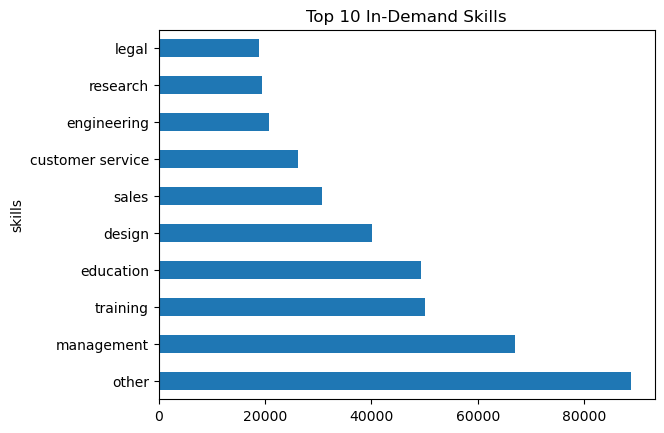

In [40]:
# here are top skills
top_skills = df['skills'].str.split(', ').explode().value_counts().head(10)
top_skills.plot(kind='barh', title='Top 10 In-Demand Skills')

<Axes: title={'center': 'Top Hiring Companies'}, ylabel='company_name'>

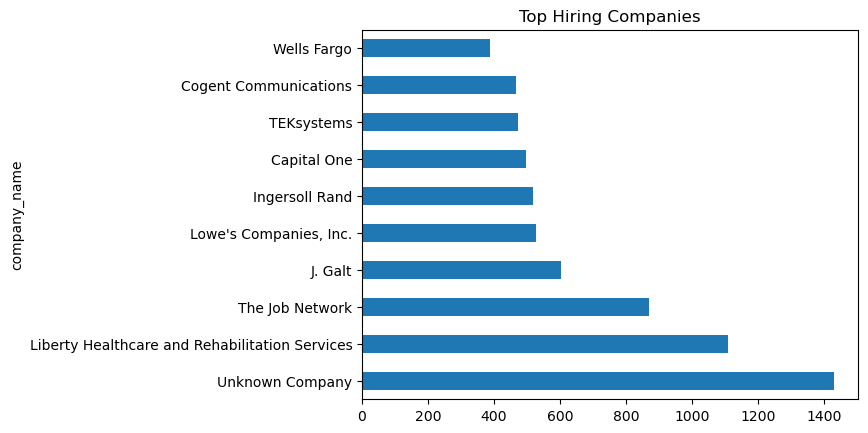

In [41]:
# jobs by Company
df['company_name'].value_counts().head(10).plot(kind='barh', title='Top Hiring Companies')

<Axes: title={'center': 'Top Hiring Locations'}, ylabel='location'>

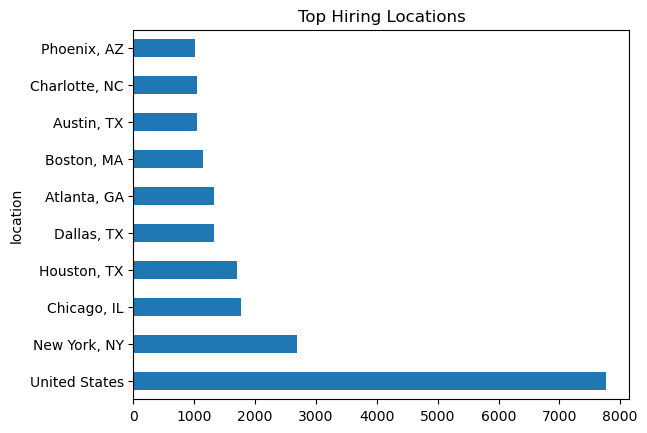

In [42]:
# jobs by Location
df['location'].value_counts().head(10).plot(kind='barh', title='Top Hiring Locations')

<Axes: xlabel='normalized_salary', ylabel='Count'>

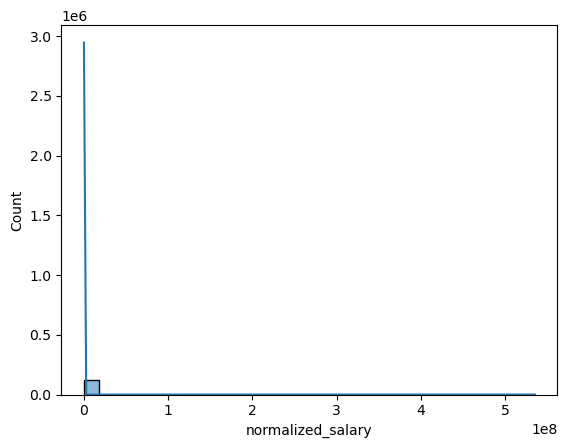

In [43]:
# Salary Distribution
sns.histplot(df['normalized_salary'], bins=30, kde=True)

In [44]:
df_exploded = df.assign(skill=df['skills'].str.split(', ')).explode('skill')
skills_by_location = df_exploded.groupby(['location', 'skill']).size().reset_index(name='count')

# now saving for Power BI
skills_by_location.to_csv("data/skills_by_location.csv", index=False)


In [45]:
skills_by_company = (
    df_exploded.groupby(["company_name", "skills"])
    .size()
    .reset_index(name="skill_count")
)
skills_by_company.to_csv("data/skills_by_company.csv", index=False)

In [46]:
skills_by_title = (
    df_exploded.groupby(["title", "skills"])
    .size()
    .reset_index(name="skill_count")
)
skills_by_title.to_csv("data/skills_by_title.csv", index=False)

In [47]:
salary_by_skill = (
    df_exploded.groupby("skills")["normalized_salary"]
    .mean()
    .reset_index(name="average_salary")
)
salary_by_skill.to_csv("data/salary_by_skill.csv", index=False)

In [48]:
df = pd.read_csv("data/final_job_market_dataset.csv")

# removing "other" from multi-skill combinations
def clean_skills(skill_str):
    if pd.isna(skill_str):
        return skill_str
    # splitting by comma, remove 'other', strip spaces, lower-case
    skills = [skill.strip().lower() for skill in skill_str.split(',') if skill.strip().lower() != 'other']
    return ', '.join(sorted(set(skills))) if skills else 'unknown'

df['skills'] = df['skills'].apply(clean_skills)

# dropping duplicates based on cleaned 'skills'
df_unique_skills = df.drop_duplicates(subset=['skills'])

# exproting now the cleaned version for Power BI
df_unique_skills.to_csv("data/cleaned_salary_by_skill.csv", index=False)

print("Exported: cleaned_salary_by_skill.csv")


Exported: cleaned_salary_by_skill.csv
